### Confidence Intervals

The goal of these series of notebooks is to provide a context of other techniques used for measuring uncertainty in machine learning (parametric models). It is specially important to understand the limitations of these methods before going through probabilistic approaches.

Particularly, this notebook will use **resampling methods** to build confidence intervals for the response variable y, model parameters and prediction error using the same data as generated in the experiment 1

A confidence interval quantifies the uncertainty on an estimated population variable, such as the mean or standard deviation

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy import stats

%matplotlib inline

#### Generate the data 

In [2]:
# Generate some linearly related data
np.random.seed(2019)

n_samples = 10000
x = np.random.random(n_samples)

sin_ = 0.4 * np.sin(x*4*np.pi)
eps = np.random.normal(scale=1.0, size=n_samples) * sin_ # noise
y_1 = 2*x + 1 
y = y_1 + eps # linear data with noise

In [3]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(y.size)
y = np.stack([y, sigma], axis=1)
x = x.reshape(x.size, 1)
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

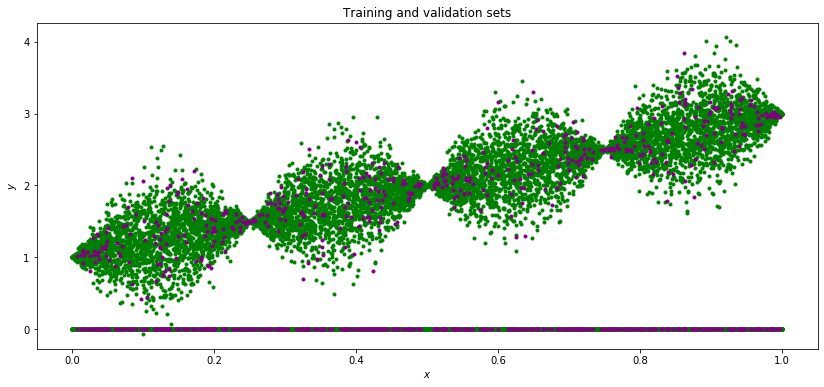

In [270]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Training and validation sets')
plt.plot(x, y, '.', color= 'green')
plt.plot(x_val, y_val, '.', color='purple')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

### Boostrapping

*Frequentist perspective of the bayesian framework*

Bayesian statistics used the following formulation based on the Bayes theorem:

$P(D \mid M) = \int_ . P(D \mid M, w)P(w)dw$

This formula has the interpretation:
    - D: The synthetic dataset 
    - M: the generative model that (we belief) better describe the process that generate that observations (1)
    - w: our prior belief over the parameters of the generative function. This is randomly sampled from the prior over functions y = f(x) and induced from the biases (error) of the model (2)

*Frequentist - Bootstrapping*
Here, we use the frequentist approach that considers data D as unknown and the model M fixed. Using this approximation, we try to search the distribution $P(M \mid D)$.

Here, we use a well-known technique used by most data scientist for assesing the uncertainty of predictions, known as Bootstrapping

In [220]:
np.random.choice(range(0, len(y)), len(y))

array([4525, 2954, 8030, ..., 8594, 4613,  231])

In [242]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

n_samples = 100

models_preds = []
models_tr_preds = []
global_models_error = []

model_errors_yhat = []
model_errors_pred = []

model_errors_std = []

coefficients = []
intercepts = []

y_yhats = []
x_samples_l = []

for i in range(0, n_samples):
    sample_index = np.random.choice(range(0, len(y)), len(y))
    x_samples = x[sample_index]
    y_samples = y[sample_index] 
    
    lr = LinearRegression()
    lr.fit(x_samples, y_samples)
    y_pred = lr.predict(x_val)
        
    # model parameters 
    coefficients.append(lr.coef_[0])
    intercepts.append(lr.intercept_[0])
    
    # estimated error in predictions (testing)
    models_preds.append(y_pred)
    
    # estimated error in predictions (training)
    y_yhat = lr.predict(x_samples)
    models_tr_preds.append(y_yhat)
    
error = lr.score(x_val,y_val) # global
global_models_error.append(error)

We fit a linear regression model in N samples with replacement taken from observed data. This gives us as a result a  sampling distribution used to calculate the standard error of the statistic or model parameters along with their confidence intervals. 

Further information about this technique: https://medium.com/@datalesdatales/the-bootstrap-or-why-you-should-care-about-uncertainty-c3fe1a5f36b5

In [243]:
# Extract Z-score 97.5 and 2.5 for the coefficients and intercept
upper_coefficient = np.percentile(coefficients, 97.5)
upper_intercept = np.percentile(intercepts, 97.5)
lower_coefficient = np.percentile(coefficients, 2.5)
lower_intercept = np.percentile(intercepts, 2.5)

#### Plot the distribution of coefficients and intercepts (model parameters)

Explanation: Here we are estimating the uncertainty in our model parameters using bootstrap sampling with the training data

This method could give us a clue of how good is our model to capture the underlying distribution of the training set.
However, it does not tell us anything about how good is the model to capture a real unknown distribution or data points far from the real mean distribution 

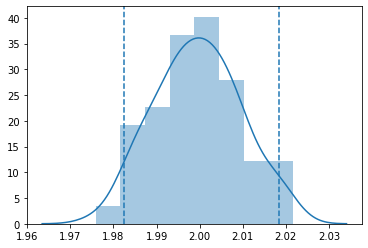

In [244]:
plt.axvline(x=upper_coefficient, linestyle='--')
plt.axvline(x=lower_coefficient, linestyle='--')
sns.distplot(coefficients)

In [245]:
stats.describe(coefficients)

DescribeResult(nobs=100, minmax=(array([1.97588663]), array([2.02164576])), mean=array([1.9995588]), variance=array([9.67609537e-05]), skewness=array([0.05454399]), kurtosis=array([-0.49546446]))

In [246]:
print('We can say that we are 95% confidence that the coefficient of the model will be between: \n {} - {}'.format(lower_coefficient, upper_coefficient))

We can say that we are 95% confidence that the coefficient of the model will be between: 
 1.9825466640061782 - 2.01843288712391


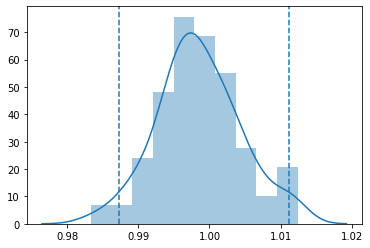

In [247]:
plt.axvline(x=upper_intercept, linestyle='--')
plt.axvline(x=lower_intercept, linestyle='--')
sns.distplot(intercepts)

In [248]:
stats.describe(intercepts)

DescribeResult(nobs=100, minmax=(0.983319519331306, 1.0123933401015075), mean=0.9985339985098253, variance=3.424954887326389e-05, skewness=0.14466277150405088, kurtosis=0.06813050229409345)

In [249]:
print('We can say that we are 95% confidence that the intercept of the model will be between: \n {} - {}'.format(lower_intercept, upper_intercept))

We can say that we are 95% confidence that the intercept of the model will be between: 
 0.9873491385607913 - 1.011108605128753


#### Plot the distribution of the mean error in predictions (model mean error distribution)

Here, confidence intervals only account for the drift in the mean response of y 

In [250]:
pred_error_variance = abs(stats.describe(models_preds).mean[:,0] - y_val[:,0])**2 

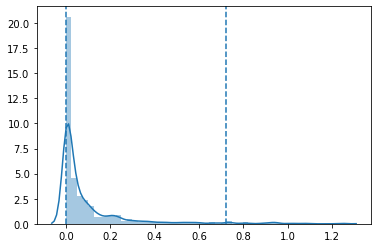

In [251]:
upper_error = np.percentile(pred_error_variance, 97.5)
lower_error = np.percentile(pred_error_variance, 2.5)
plt.axvline(x=upper_error, linestyle='--')
plt.axvline(x=lower_error, linestyle='--')
sns.distplot(pred_error_variance)

In [252]:
print('We can say that we are 95% confidence that the global error of the model predictions will be between: \n {} - {}'.format(lower_error, upper_error))

We can say that we are 95% confidence that the global error of the model predictions will be between: 
 7.052991712126867e-06 - 0.7232967623190483


#### Visualization of the error variance for each prediction

Here we can see the error variance as a result of the resampling process, in this case in the predictions made over the validation with the N models fitted in n_samples

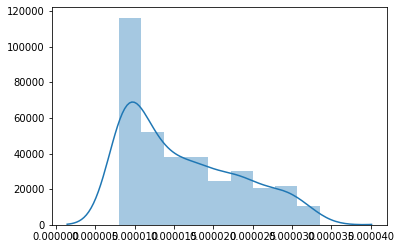

In [253]:
pred_variance = stats.describe(models_preds).variance[:,0]
sns.distplot(pred_variance)

#### Visualization of the point estimation variance

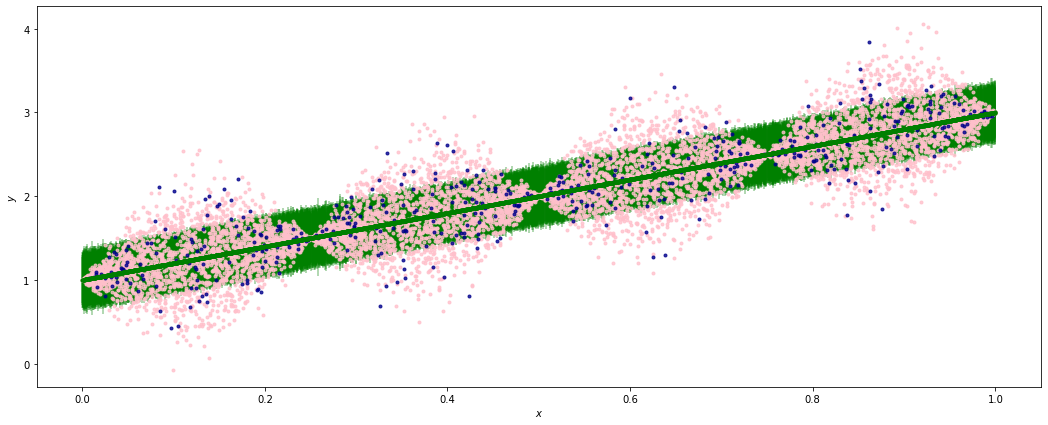

In [268]:
plt.figure(figsize=(18,7))

plt.plot(x, y[:,0], '.', color='pink', alpha=0.8)
plt.plot(x_val, y_val[:,0], '.', color='darkblue', alpha=0.8)
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

plt.errorbar(x, y_1[n_validation:], yerr=stats.describe(models_tr_preds).variance[:,0], color='green', fmt='.', alpha=0.4)
plt.show()

This method is not valid for point estimation variance. As we can see the variance in predictions made with different samples of the training set is homocedastic

### Conclusions

This method could help us to measure the epistemic uncertainty of our model

***
The bootstrap method doesn’t necessarily involve any assumptions about the data or the sample statistic being normally distributed.
***
 
 
    - We can explain to the client relationships extracted from data using confidence intervals. This is specially useful in cases where we know that our training data is not representative enough of the real population distribution (parameters) 
    - We can identify when we should choose for a more complex model (we look for the narrower confidence interval). High variance may suggest to go towards a more complex model
    - It could highlight the effects of excluding relevant information (we could condition the resampling method to exclude or include some particular data)
    

### Limitations

    1 - It is unfeasible to run this technique for measuring the uncertainty in complex models with more variables and high number of parameters. (e.g deep neural networks)
    2 - It's not good for estimating the error of a single prediction. (Explanation based on 3.)
    3 - The confidence intervals of the prediction residuals obtained here are approximates to a normal distribution due to the central limit theorem. 

### Future Steps

List of the frequentist techniques proposed for comparison:
* Cross-validation*
* Conformal Predictors
* Quantile Regression
* Gradient Boosting
* fbprophet
* Mean Variance Estimation
* The Delta Method


State of the art of predicting the uncertainty using a frequentist approach:
* Deep Ensambles: https://deepmind.com/research/publications/simple-and-scalable-predictive-uncertainty-estimation-using-deep-ensembles

### References

[1] [High-Quality Prediction Intervals for Deep Learning:
A Distribution-Free, Ensembled Approach](https://arxiv.org/pdf/1802.07167.pdf)

